## Throughput Graph

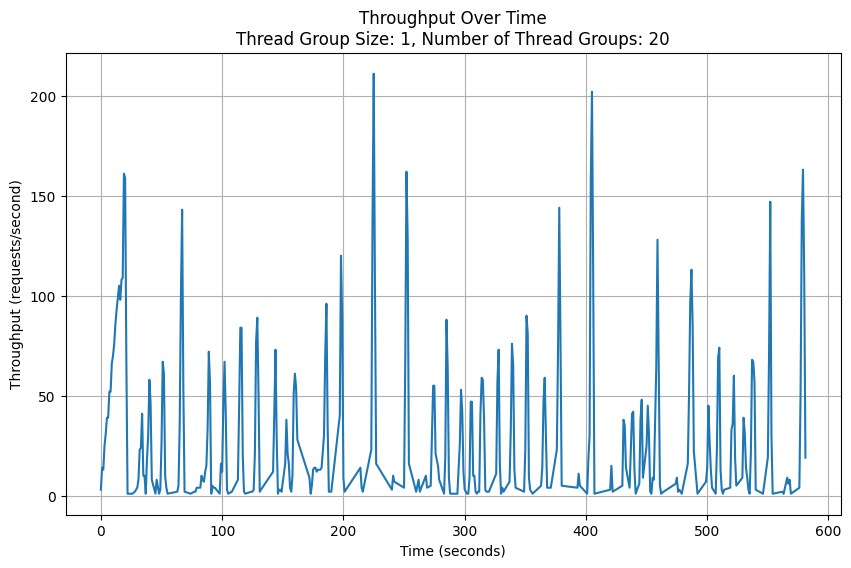

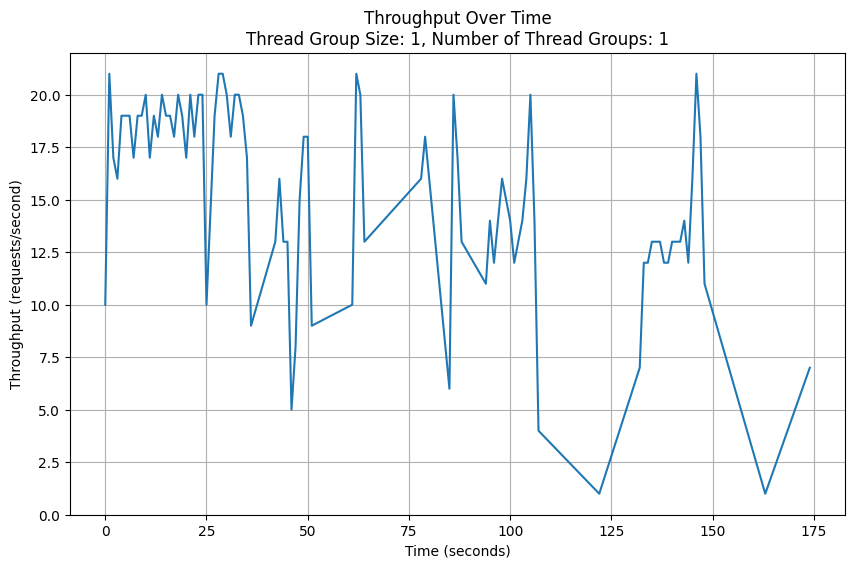

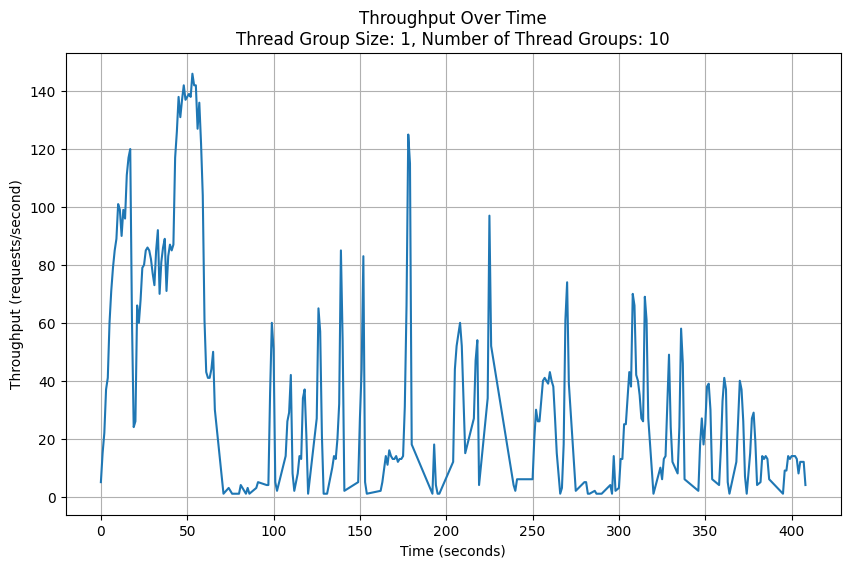

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

# Get all CSV files matching the pattern "response_time_size-*_*.csv" in the current folder
csv_files = glob.glob('response_time_size-*_*.csv')

# Initialize an empty list to hold all the data
all_data = []

# Load each CSV file and append the data to the list
for csv_file in csv_files:
    data = pd.read_csv(csv_file)
    all_data.append((csv_file, data))

# Check if there are any CSV files to process
if all_data:
    for csv_file, data in all_data:
        # Extract threadGroupSize and numThreadGroups from the file name
        match = re.search(r'response_time_size-(\d+)_(\d+)_groups\.csv', csv_file)
        if match:
            threadGroupSize = match.group(1)
            numThreadGroups = match.group(2)

            # Convert start_time from milliseconds to seconds
            data['start_time'] = data['start_time'] // 1000

            # Calculate the throughput per second
            throughput = data.groupby('start_time').size()

            # Plot the graph
            plt.figure(figsize=(10, 6))
            plt.plot(throughput.index - throughput.index.min(), throughput.values)
            plt.xlabel('Time (seconds)')
            plt.ylabel('Throughput (requests/second)')
            plt.title(f'Throughput Over Time\nThread Group Size: {threadGroupSize}, Number of Thread Groups: {numThreadGroups}')
            plt.grid(True)
            plt.show()
else:
    print("No CSV files found matching the pattern 'response_time_size-*_*.csv'")

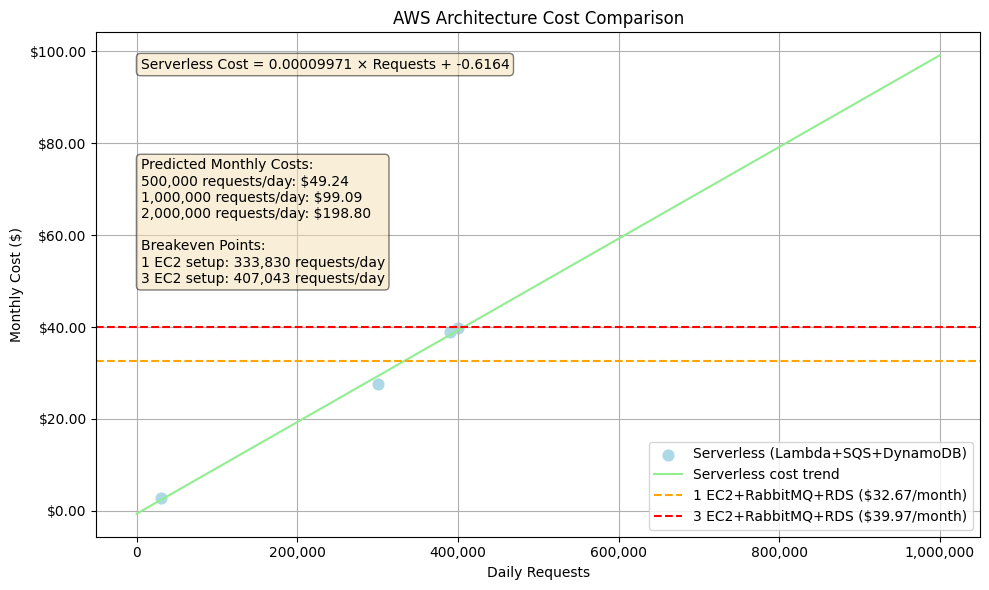

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter

import matplotlib.pyplot as plt

# Create a DataFrame from the provided data
data = {
    'Daily Requests': [30000, 300000, 390000, 400000],
    'Monthly Cost': [2.79, 27.70, 38.88, 39.84]
}

df = pd.DataFrame(data)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Daily Requests'], df['Monthly Cost'], color='lightblue', s=60, label='Serverless (Lambda+SQS+DynamoDB)')

# Create and fit a linear regression model
model = LinearRegression()
X = df['Daily Requests'].values.reshape(-1, 1)
y = df['Monthly Cost'].values
model.fit(X, y)

# Generate points for the regression line
x_range = np.linspace(0, 1000000, 100).reshape(-1, 1)
y_pred = model.predict(x_range)

# Plot the regression line
plt.plot(x_range, y_pred, color='lightgreen', label='Serverless cost trend')

# Add horizontal lines for EC2 costs
plt.axhline(y=32.67, color='orange', linestyle='--', label='1 EC2+RabbitMQ+RDS ($32.67/month)')
plt.axhline(y=39.97, color='red', linestyle='--', label='3 EC2+RabbitMQ+RDS ($39.97/month)')

# Format axes with thousands separator and dollar sign
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:.2f}'))

# Get slope and intercept for the equation
slope = model.coef_[0]
intercept = model.intercept_

# Add labels and title
plt.xlabel('Daily Requests')
plt.ylabel('Monthly Cost ($)')
plt.title('AWS Architecture Cost Comparison')
plt.grid(True)
plt.legend()

# Add text box with equation and predictions
equation_text = f'Serverless Cost = {slope:.8f} × Requests + {intercept:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# Function to predict cost
def predict_cost(daily_requests):
    return model.predict([[daily_requests]])[0]

# Calculate breakeven points
breakeven_1ec2 = (32.67 - intercept) / slope
breakeven_3ec2 = (39.97 - intercept) / slope

# Example cost predictions with breakeven points
example_requests = [500000, 1000000, 2000000]
prediction_text = "Predicted Monthly Costs:\n"
for req in example_requests:
    predicted_cost = predict_cost(req)
    prediction_text += f"{req:,} requests/day: ${predicted_cost:.2f}\n"
    
prediction_text += f"\nBreakeven Points:\n"
prediction_text += f"1 EC2 setup: {int(breakeven_1ec2):,} requests/day\n"
prediction_text += f"3 EC2 setup: {int(breakeven_3ec2):,} requests/day"

# Add prediction text box
plt.text(0.05, 0.75, prediction_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()